
# [Kaggle: Spooky Author Identification](https://www.kaggle.com/c/spooky-author-identification/overview)

Have you ever wondered how to build Spark Natural Langiage Processing Machine Learning Pipelines for scale? Do you want to convert your scikit-learn and pandas based NLP ML workflow and take it to scale using Spark? Would it have been better if you had an working end-to-end example to refer and that too from a past Kaggle competition to refer? Then Read On...  

`@author: Anindya Saha`  
`@email: mail.anindya@gmail.com`  

I hope you enjoy reviewing it as much as I had writing it.

![](assets/kaggle.png)

## Problem Statement:
In this notebook, we try to predict the author of excerpts from horror stories by Edgar Allan Poe, Mary Shelley, and HP Lovecraft. The goal of the notebook is not to get too fancy with the choice of the Algorithms but its more on how can you use Spark to achieve or at least try to achieve what you could do using scikit-learn and pandas. The dataset can be downloaded from the [Kaggle](https://www.kaggle.com/c/spooky-author-identification/data) competition page.

According to the competition page there are three distinct author initials we have already been provided with a mapping of these initials to the actual author which is as follows:

Ref: [2](https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial)

[EAP - Edgar Allen Poe](https://en.wikipedia.org/wiki/Edgar_Allan_Poe) : American writer who wrote poetry and short stories that revolved around tales of mystery and the grisly and the grim. Arguably his most famous work is the poem - "The Raven" and he is also widely considered the pioneer of the genre of the detective fiction.

[HPL - HP Lovecraft](https://en.wikipedia.org/wiki/H._P._Lovecraft) : Best known for authoring works of horror fiction, the stories that he is most celebrated for revolve around the fictional mythology of the infamous creature "Cthulhu" - a hybrid chimera mix of Octopus head and humanoid body with wings on the back.

[MWS - Mary Shelley](https://en.wikipedia.org/wiki/Mary_Shelley) : Seemed to have been involved in a whole panoply of literary pursuits - novelist, dramatist, travel-writer, biographer. She is most celebrated for the classic tale of Frankenstein where the scientist Frankenstein a.k.a "The Modern Prometheus" creates the Monster that comes to be associated with his name.

### Pre-requisites
+ pip install nltk
+ python -m nltk.downloader all
+ pip install wordcloud

In [1]:
import re
import nltk
import string
import unicodedata

from pyspark.sql import SparkSession, SQLContext

import pyspark.sql.functions as F
from pyspark.sql.types import StructField, StructType, ArrayType, IntegerType, StringType

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, Word2Vec, StringIndexer, IndexToString, VectorAssembler

In [2]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

In [3]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

sns.set(context='notebook', style='whitegrid', rc={"figure.figsize": (18,4)})

In [4]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 50)

In [5]:
rnd_seed = 42

## 1. Create Spark Session

In [6]:
spark = (SparkSession
         .builder
         .master("local[*]")
         .appName("kaggle-spooky-author-identification")
         .getOrCreate())

In [7]:
spark

## 2. Load The Data From Files Into Dataframes

In [8]:
DATA_PATH = '/mnt/user-home/Data-Science-with-Spark/kaggle-spooky-author-identification/data'

In [9]:
train_df = spark.read.csv(f'{DATA_PATH}/train.csv', sep=',', escape='"', header=True)

In [10]:
train_df.cache()

DataFrame[id: string, text: string, author: string]

In [11]:
train_df.show(5, truncate=50)

+-------+--------------------------------------------------+------+
|     id|                                              text|author|
+-------+--------------------------------------------------+------+
|id26305|This process, however, afforded me no means of ...|   EAP|
|id17569|It never once occurred to me that the fumbling ...|   HPL|
|id11008|In his left hand was a gold snuff box, from whi...|   EAP|
|id27763|How lovely is spring As we looked from Windsor ...|   MWS|
|id12958|Finding nothing else, not even gold, the Superi...|   HPL|
+-------+--------------------------------------------------+------+
only showing top 5 rows



In [12]:
# in production with large datasets you may want to repartition the data
# train_df = train_df.repartition("author").cache()

### 2.1. How many Unique Authors

In [13]:
train_df.select('author').distinct().show()

+------+
|author|
+------+
|   HPL|
|   MWS|
|   EAP|
+------+



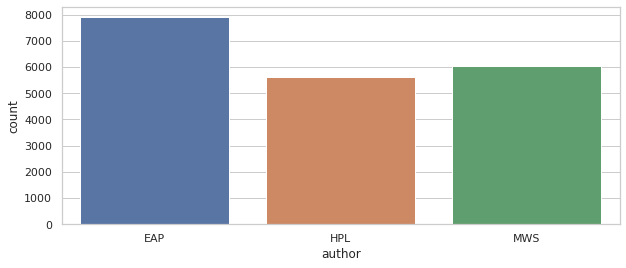

In [14]:
plt.figure(figsize=(10,4))
sns.countplot(x='author', data=train_df.select('author').toPandas());

## 3. Understanding the Tokenizer and Other NLP Transformers

In this section we will build a basic word tokenizer and see how can we generate features for Machine Learning.

### 3.1. Basic sentence tokenizer

In [15]:
# Basic sentence tokenizer
tokenizer_tf = Tokenizer(inputCol="text", outputCol="tokens")

In [16]:
tokens_df = tokenizer_tf.transform(train_df)

In [17]:
tokens_df.cache()

DataFrame[id: string, text: string, author: string, tokens: array<string>]

In [18]:
tokens_df.show(5, truncate=45)

+-------+---------------------------------------------+------+---------------------------------------------+
|     id|                                         text|author|                                       tokens|
+-------+---------------------------------------------+------+---------------------------------------------+
|id26305|This process, however, afforded me no mean...|   EAP|[this, process,, however,, afforded, me, n...|
|id17569|It never once occurred to me that the fumb...|   HPL|[it, never, once, occurred, to, me, that, ...|
|id11008|In his left hand was a gold snuff box, fro...|   EAP|[in, his, left, hand, was, a, gold, snuff,...|
|id27763|How lovely is spring As we looked from Win...|   MWS|[how, lovely, is, spring, as, we, looked, ...|
|id12958|Finding nothing else, not even gold, the S...|   HPL|[finding, nothing, else,, not, even, gold,...|
+-------+---------------------------------------------+------+---------------------------------------------+
only showing top 5 

In [19]:
tokens_df.select('tokens').take(5)

[Row(tokens=['this', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'i', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'i', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.']),
 Row(tokens=['it', 'never', 'once', 'occurred', 'to', 'me', 'that', 'the', 'fumbling', 'might', 'be', 'a', 'mere', 'mistake.']),
 Row(tokens=['in', 'his', 'left', 'hand', 'was', 'a', 'gold', 'snuff', 'box,', 'from', 'which,', 'as', 'he', 'capered', 'down', 'the', 'hill,', 'cutting', 'all', 'manner', 'of', 'fantastic', 'steps,', 'he', 'took', 'snuff', 'incessantly', 'with', 'an', 'air', 'of', 'the', 'greatest', 'possible', 'self', 'satisfaction.']),
 Row(tokens=['how', 'lovely', 'is', 'spring', 'as', 'we', 'looked', 'from', 'windsor', 'terrace', 'on', 'the', 'sixteen', 'fertile', 'counties', 'spread', 'beneath,', 'speckled'

In [20]:
tokens_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)



### 3.2. WordClouds to visualise each author's work

Let us visualize the words used by each author by plotting a `WordCloud`. A word cloud (as the name suggests) is an image that is made up of a mixture of distinct words which may make up a text or book and where the size of each word is proportional to its word frequency in that text (number of times the word appears). Here instead of dealing with an actual book or text, our words can simply be taken from the column `tokens`.

We need to apply a series of Spark functions to get all the tokens for a given author:
+ Each row in the Dataframe is a token array.
+ So, when we group by each author, we collect tokens as an `array of arrays` using `collect_list` function for each author.
+ And, then finally flatten out the array of arrays into one array using `flatten` function and collect them into the `all_tokens` column.

In [21]:
tokens_by_author_df = (tokens_df
                      .groupBy('author')
                      .agg(F.flatten(
                            F.collect_list('tokens')).alias('all_tokens')))
tokens_by_author_df.cache()

DataFrame[author: string, all_tokens: array<string>]

In [22]:
tokens_by_author_df.show(truncate=75)

+------+---------------------------------------------------------------------------+
|author|                                                                 all_tokens|
+------+---------------------------------------------------------------------------+
|   HPL|[it, never, once, occurred, to, me, that, the, fumbling, might, be, a, m...|
|   MWS|[how, lovely, is, spring, as, we, looked, from, windsor, terrace, on, th...|
|   EAP|[this, process,, however,, afforded, me, no, means, of, ascertaining, th...|
+------+---------------------------------------------------------------------------+



In [23]:
# verify that the array has been flattened; each element off `all_tokens` should be a string
tokens_by_author_df.printSchema()

root
 |-- author: string (nullable = true)
 |-- all_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [24]:
# verify that the array has been flattened; extract out the first token for each author
tokens_by_author_df.select('author', F.element_at('all_tokens', 1).alias('first_token')).show()

+------+-----------+
|author|first_token|
+------+-----------+
|   HPL|         it|
|   MWS|        how|
|   EAP|       this|
+------+-----------+



Yay! So, our tokenziation and extraction are working fine.

**Extract out inidividual Author's tokens for WordCloud**

In [25]:
hpl_tokens = tokens_by_author_df.filter(F.col('author') == 'HPL').select('all_tokens').take(1)
mws_tokens = tokens_by_author_df.filter(F.col('author') == 'MWS').select('all_tokens').take(1)
eap_tokens = tokens_by_author_df.filter(F.col('author') == 'EAP').select('all_tokens').take(1)

In [26]:
# quick type checking
type(eap_tokens), len(eap_tokens), type(eap_tokens[0]), type(eap_tokens[0].all_tokens)

(list, 1, pyspark.sql.types.Row, list)

Each row of `hpl_tokens` or `mws_tokens` or `eap_tokens` is a `pyspark.sql.types.Row` object. We still need to extract out the Python string array from the `pyspark.sql.types.Row:eap_tokens` via `eap_tokens[0].all_tokens`.

In [27]:
# plot the word cloud from the tokens
from wordcloud import WordCloud, STOPWORDS
def plot_word_cloud(tokens, title):
    plt.figure(figsize=(14, 12))
    wc = WordCloud(background_color="black", max_words=10000, stopwords=STOPWORDS, max_font_size= 40)
    wc.generate(" ".join(tokens))
    plt.title(title, fontsize=18)
    # plt.imshow(wc.recolor(colormap='Pastel1_r', random_state=23), alpha=0.98)
    plt.imshow(wc.recolor(colormap='Pastel2', random_state=23), alpha=0.98)
    plt.axis('off');

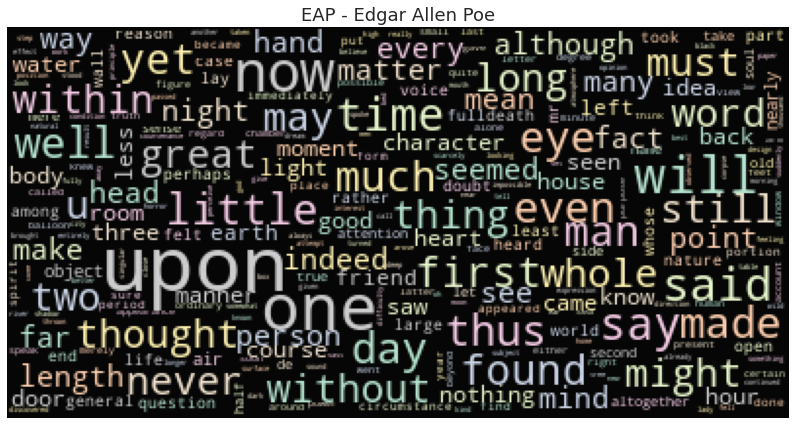

In [28]:
plot_word_cloud(eap_tokens[0].all_tokens, "EAP - Edgar Allen Poe")

EAP - Edgar Allen Poe works revolved around tales of mystery and the grisly and the grim. We can see the usage of `body`, `head`, `heart` in his works.

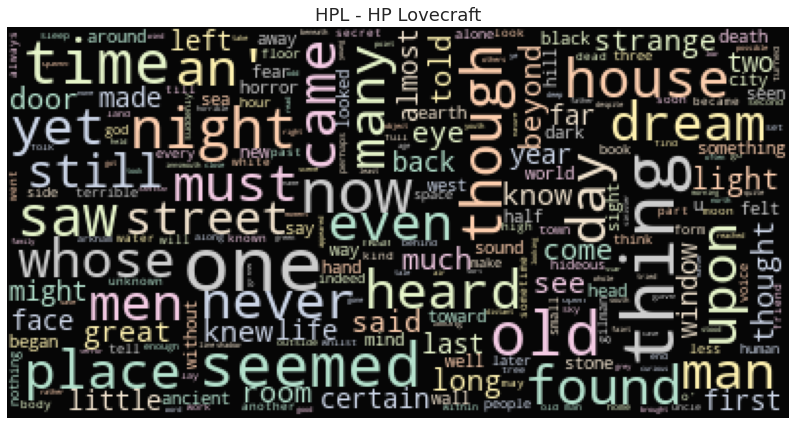

In [29]:
plot_word_cloud(hpl_tokens[0].all_tokens, "HPL - HP Lovecraft")

HPL - HP Lovecraft's  works revolved around fictional mythology. We can see the usage of `dream`, `eye`, `strange` in his works.

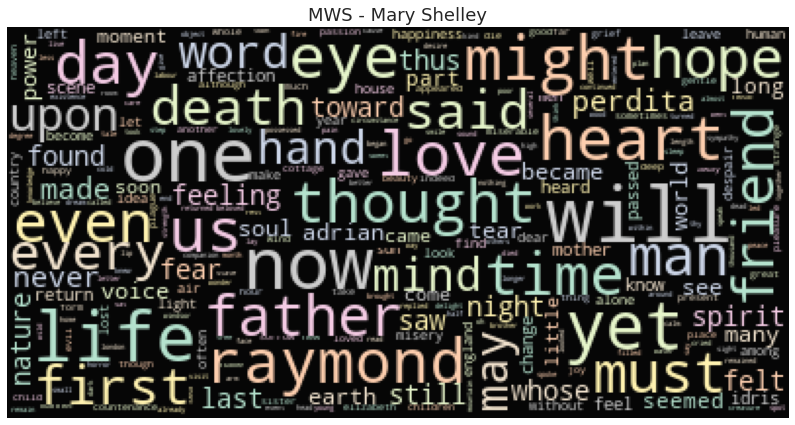

In [30]:
plot_word_cloud(mws_tokens[0].all_tokens, "MWS - Mary Shelley")

MWS - Mary Shelley seemed to be a versatile author. I do not find any distinctive choice of words. 

### 3.2. Count Words in the Document

In [31]:
# Count the words in a document
hashing_tf = HashingTF(inputCol="tokens", outputCol="hashed_features")

In [32]:
hashed_df = hashing_tf.transform(tokens_df)

In [33]:
hashed_df.cache()

DataFrame[id: string, text: string, author: string, tokens: array<string>, hashed_features: vector]

In [34]:
hashed_df.show(10, truncate=30)

+-------+------------------------------+------+------------------------------+------------------------------+
|     id|                          text|author|                        tokens|               hashed_features|
+-------+------------------------------+------+------------------------------+------------------------------+
|id26305|This process, however, affo...|   EAP|[this, process,, however,, ...|(262144,[239,19036,27576,34...|
|id17569|It never once occurred to m...|   HPL|[it, never, once, occurred,...|(262144,[24284,27576,30950,...|
|id11008|In his left hand was a gold...|   EAP|[in, his, left, hand, was, ...|(262144,[25217,28338,42404,...|
|id27763|How lovely is spring As we ...|   MWS|[how, lovely, is, spring, a...|(262144,[19245,29423,42404,...|
|id12958|Finding nothing else, not e...|   HPL|[finding, nothing, else,, n...|(262144,[2128,32983,33917,3...|
|id22965|A youth passed in solitude,...|   MWS|[a, youth, passed, in, soli...|(262144,[7075,13938,15494,1...|
|id09674|T

In [35]:
hashed_df.take(1)

[Row(id='id26305', text='This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.', author='EAP', tokens=['this', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'i', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'i', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.'], hashed_features=SparseVector(262144, {239: 1.0, 19036: 2.0, 27576: 1.0, 34188: 1.0, 42924: 1.0, 50001: 1.0, 51910: 1.0, 69205: 1.0, 80158: 1.0, 82544: 1.0, 88590: 1.0, 89717: 1.0, 91767: 1.0, 95889: 4.0, 98726: 1.0, 108541: 1.0, 117491: 1.0, 118667: 1.0, 124786: 1.0, 140315: 1.0, 148880: 1.0, 158069: 1.0, 160249: 1.0, 162916: 1.0, 183339: 1.0, 186312: 1.0, 1985

### 3.3. Calculate TF-IDF of the tokens

In [36]:
# Build the idf model and transform the original token frequencies into their tf-idf counterparts
idf_tf = IDF(inputCol="hashed_features", outputCol="tfidf_features")

In [37]:
idf_model = idf_tf.fit(hashed_df)

In [38]:
tfidf_df = idf_model.transform(hashed_df)

In [39]:
tfidf_df.cache()

DataFrame[id: string, text: string, author: string, tokens: array<string>, hashed_features: vector, tfidf_features: vector]

In [40]:
tfidf_df.select('id', 'author', 'tokens', 'hashed_features', 'tfidf_features').show(5, truncate=30)

+-------+------+------------------------------+------------------------------+------------------------------+
|     id|author|                        tokens|               hashed_features|                tfidf_features|
+-------+------+------------------------------+------------------------------+------------------------------+
|id26305|   EAP|[this, process,, however,, ...|(262144,[239,19036,27576,34...|(262144,[239,19036,27576,34...|
|id17569|   HPL|[it, never, once, occurred,...|(262144,[24284,27576,30950,...|(262144,[24284,27576,30950,...|
|id11008|   EAP|[in, his, left, hand, was, ...|(262144,[25217,28338,42404,...|(262144,[25217,28338,42404,...|
|id27763|   MWS|[how, lovely, is, spring, a...|(262144,[19245,29423,42404,...|(262144,[19245,29423,42404,...|
|id12958|   HPL|[finding, nothing, else,, n...|(262144,[2128,32983,33917,3...|(262144,[2128,32983,33917,3...|
+-------+------+------------------------------+------------------------------+------------------------------+
only showi

In [41]:
tfidf_df.select('tfidf_features').take(1)

[Row(tfidf_features=SparseVector(262144, {239: 8.496, 19036: 2.0973, 27576: 0.818, 34188: 5.8047, 42924: 9.1891, 50001: 2.4363, 51910: 9.1891, 69205: 7.5797, 80158: 9.1891, 82544: 6.7912, 88590: 6.6634, 89717: 4.3025, 91767: 6.3269, 95889: 1.259, 98726: 6.1211, 108541: 2.1534, 117491: 2.7183, 118667: 6.3269, 124786: 4.1852, 140315: 2.881, 148880: 4.865, 158069: 4.8388, 160249: 3.9934, 162916: 3.6304, 183339: 4.013, 186312: 2.594, 198589: 1.8636, 209518: 4.9406, 219087: 1.614, 219915: 0.5915, 221027: 7.8028, 240944: 1.6174, 256468: 3.5437, 257069: 8.0905, 261675: 5.0782}))]

## 4. Create advanced Tokenizer

In this section we will build a custom word tokenizer where we:
+ Create the word tokens (lemmatize words, remove stop words and punctuations, strip off html and digits)
+ Count the number of punctuations in a sentence (can be a useful feature)
+ Count the number of words in a sentence (can be a useful feature)

### 4.1. Create Tokenizer based on Lemmatization

In [42]:
# Tokenize sentence (lemmatize words, remove stop words and punctuations, strip off html and digits)
# Returns a struct of tokens, tokens count, punctuation count
def lemmatize(text):
    """
    param: sentence
    return: tokens, tokens count, punctuation count
    """
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = set(nltk.corpus.stopwords.words('english'))
    list_punct=set(string.punctuation)
    
    punct_count = sum([1 for ch in text if ch in list_punct])
    
    text = (unicodedata.normalize('NFKD', text)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    # remove urls
    text = re.sub(r'https?.+|[^(a-zA-Z)(0-9)\s]', ' ', text)
    # remove numbers
    text = re.sub(r'\d+', ' ', text)
    
    words = text.split()
    # remove stopwords and strings of length <= 2
    words = [wnl.lemmatize(word) for word in words if word not in stopwords and len(word) > 2]
    word_count = len(words)
    
    return words, word_count, punct_count

In [43]:
lemmatize("#trump:a,wOrds.c      .dd. 123 https://asdasdf, http://asdasdf,")

(['trump', 'word'], 2, 14)

In [44]:
assert (['trump', 'word'], 2, 14) == lemmatize("#trump:a,wOrds.c      .dd. 123 https://asdasdf, http://asdasdf,")

In [45]:
lemmatize("""This process, however, afforded me no means of ascertaining the dimensions of my dungeon;
          as I might make its circuit, and return to the point whence I set out, without being aware of the fact;
          so perfectly uniform seemed the wall.
          """)

(['process',
  'however',
  'afforded',
  'mean',
  'ascertaining',
  'dimension',
  'dungeon',
  'might',
  'make',
  'circuit',
  'return',
  'point',
  'whence',
  'set',
  'without',
  'aware',
  'fact',
  'perfectly',
  'uniform',
  'seemed',
  'wall'],
 21,
 7)

## 5. Preparing Features for Machine Learning

### 5.1. Use Custom Tokenizer to extract Tokens from text

In [46]:
# Register lemmatizer as an UDF
lemma_schema = StructType([
    StructField("words", ArrayType(StringType()), False),
    StructField("word_count", IntegerType(), False),
    StructField("punct_count", IntegerType(), False)
])

udf_lemmatize = F.udf(lemmatize, lemma_schema)

In [47]:
# Use the UDF to extract the tokens and count features
lemma_train_df = (train_df
 .withColumn('lemmatize', udf_lemmatize('text'))
)

In [48]:
lemma_train_df.cache()

DataFrame[id: string, text: string, author: string, lemmatize: struct<words:array<string>,word_count:int,punct_count:int>]

In [49]:
lemma_train_df.show(5, truncate=40)

+-------+----------------------------------------+------+----------------------------------------+
|     id|                                    text|author|                               lemmatize|
+-------+----------------------------------------+------+----------------------------------------+
|id26305|This process, however, afforded me no...|   EAP|[[process, however, afforded, mean, a...|
|id17569|It never once occurred to me that the...|   HPL|[[never, occurred, fumbling, might, m...|
|id11008|In his left hand was a gold snuff box...|   EAP|[[left, hand, gold, snuff, box, caper...|
|id27763|How lovely is spring As we looked fro...|   MWS|[[lovely, spring, looked, windsor, te...|
|id12958|Finding nothing else, not even gold, ...|   HPL|[[finding, nothing, else, even, gold,...|
+-------+----------------------------------------+------+----------------------------------------+
only showing top 5 rows



### 5.2. WordClouds of the lemmatized tokens to visualise each author's work

Since, we now have a better tokenizer, we can leverage the similar strategy from section 3.2 above to visualize the words used by each author by plotting a `WordCloud`. 

We need to apply a series of Spark functions to get all the tokens for a given author:
+ Each row in the Dataframe is a token array.
+ So, when we group by each author, we collect tokens as an `array of structs` using `collect_list` function for each author.
+ And, then Finally flatten out the array of structs into one array using `flatten` function and collect them into the `words` column.

In [50]:
words_by_author_df = (lemma_train_df
                     .groupBy('author')
                     .agg(F.flatten(
                            F.collect_list('lemmatize.words')).alias('words'))
                     .cache())

In [51]:
words_by_author_df.show()

+------+--------------------+
|author|               words|
+------+--------------------+
|   HPL|[never, occurred,...|
|   MWS|[lovely, spring, ...|
|   EAP|[process, however...|
+------+--------------------+



In [52]:
# verify that the array has been flattened; each element off `all_tokanes` should be a string
words_by_author_df.printSchema()

root
 |-- author: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)



**Extract out inidividual author's tokens for WordCloud**

In [53]:
hpl_tokens = words_by_author_df.filter(F.col('author') == 'HPL').select('words').take(1)
mws_tokens = words_by_author_df.filter(F.col('author') == 'MWS').select('words').take(1)
eap_tokens = words_by_author_df.filter(F.col('author') == 'EAP').select('words').take(1)

In [54]:
# quick type checking
type(eap_tokens), len(eap_tokens), type(eap_tokens[0]), type(eap_tokens[0].words)

(list, 1, pyspark.sql.types.Row, list)

Like before in section 3.2,  each row of `hpl_tokens` or `mws_tokens` or `eap_tokens` is a `pyspark.sql.types.Row` object. We still need to extract out the Python string array from the `pyspark.sql.types.Row:eap_tokens` via `eap_tokens[0].words`.

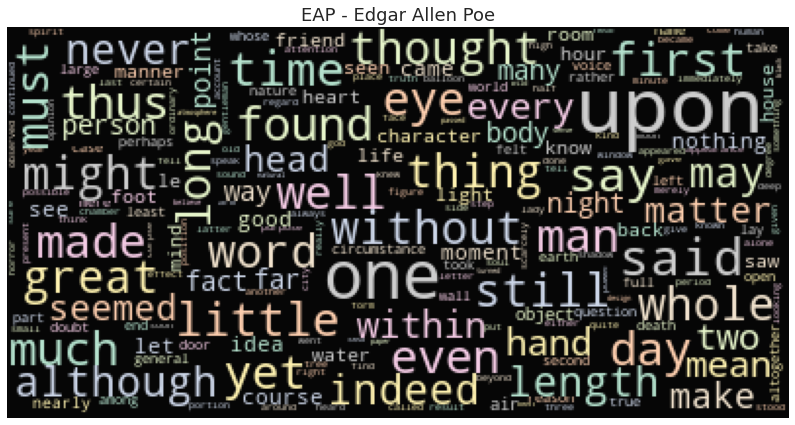

In [55]:
plot_word_cloud(eap_tokens[0].words, "EAP - Edgar Allen Poe")

### 5.3. Unwrap StructType Column `lemmatize` to generate individual feature columns

In [56]:
lemma_train_df = lemma_train_df.select(F.col("text"),
                    F.col("author"), 
                    F.col("lemmatize.words").alias("words"),
                    F.col("lemmatize.word_count").alias("word_count"),
                    F.col("lemmatize.punct_count").alias("punct_count")
                   ).cache()

In [57]:
lemma_train_df.show(truncate=30)

+------------------------------+------+------------------------------+----------+-----------+
|                          text|author|                         words|word_count|punct_count|
+------------------------------+------+------------------------------+----------+-----------+
|This process, however, affo...|   EAP|[process, however, afforded...|        21|          7|
|It never once occurred to m...|   HPL|[never, occurred, fumbling,...|         6|          1|
|In his left hand was a gold...|   EAP|[left, hand, gold, snuff, b...|        19|          5|
|How lovely is spring As we ...|   MWS|[lovely, spring, looked, wi...|        21|          4|
|Finding nothing else, not e...|   HPL|[finding, nothing, else, ev...|        16|          4|
|A youth passed in solitude,...|   MWS|[youth, passed, solitude, b...|        40|          6|
|The astronomer, perhaps, at...|   EAP|[astronomer, perhaps, point...|        12|          5|
|The surcingle hung in riban...|   EAP|[surcingle, hung, rib

In [58]:
lemma_train_df.printSchema()

root
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- word_count: integer (nullable = true)
 |-- punct_count: integer (nullable = true)



### 5.4. Convert BoW to Word2Vec Vector

They are several ways to transform a BoW to an vector. `tf-idf` and `word2Vec` are pretty popular. We saw examples of `tf-idf` vectorization in [Section 3](#3.3.-Calculate-TF-IDF-of-the-tokens).

In this section we will try out a `Word2Vec` Vector using the `from pyspark.ml.feature import Word2Vec` transformer.

In [59]:
word2Vec = Word2Vec(vectorSize=100, 
                    minCount=1, 
                    inputCol="words", 
                    outputCol="w2v_features",
                    maxIter=20,
                    seed=rnd_seed)

In [60]:
w2vec_model = word2Vec.fit(lemma_train_df)

In [61]:
w2v_train_df = w2vec_model.transform(lemma_train_df)

In [62]:
w2v_train_df.cache()

DataFrame[text: string, author: string, words: array<string>, word_count: int, punct_count: int, w2v_features: vector]

In [63]:
w2v_train_df.show(truncate=25)

+-------------------------+------+-------------------------+----------+-----------+-------------------------+
|                     text|author|                    words|word_count|punct_count|             w2v_features|
+-------------------------+------+-------------------------+----------+-----------+-------------------------+
|This process, however,...|   EAP|[process, however, aff...|        21|          7|[-0.04508726955169723,...|
|It never once occurred...|   HPL|[never, occurred, fumb...|         6|          1|[-0.02202036790549755,...|
|In his left hand was a...|   EAP|[left, hand, gold, snu...|        19|          5|[0.120830607845595,-0....|
|How lovely is spring A...|   MWS|[lovely, spring, looke...|        21|          4|[-0.1804231609262171,-...|
|Finding nothing else, ...|   HPL|[finding, nothing, els...|        16|          4|[0.15754939219914377,0...|
|A youth passed in soli...|   MWS|[youth, passed, solitu...|        40|          6|[-0.03963116165396059,...|
|The astro

### 5.5. Append count features to Word2Vec features with `VectorAssembler`

In [64]:
feature_cols = ["w2v_features", "word_count", "punct_count"]

In [65]:
# put features into a feature vector column
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features") 

In [66]:
assembled_train_df = vector_assembler.transform(w2v_train_df)

In [67]:
assembled_train_df.cache()

DataFrame[text: string, author: string, words: array<string>, word_count: int, punct_count: int, w2v_features: vector, features: vector]

In [68]:
assembled_train_df.select('author', 'features').show(5, truncate=75)

+------+---------------------------------------------------------------------------+
|author|                                                                   features|
+------+---------------------------------------------------------------------------+
|   EAP|[-0.04508726955169723,-0.22176857055663796,0.07184775741604556,-0.034226...|
|   HPL|[-0.02202036790549755,-0.05588013283947172,-0.07168043466905752,0.138459...|
|   EAP|[0.120830607845595,-0.07930856472567507,-0.012832334363146831,-0.1258247...|
|   MWS|[-0.1804231609262171,-0.08325444534420967,0.012918848641371975,0.1724678...|
|   HPL|[0.15754939219914377,0.12177808140404522,0.07104403374250978,0.084308740...|
+------+---------------------------------------------------------------------------+
only showing top 5 rows



In [69]:
# check the original individual feature columns
assembled_train_df.select('w2v_features', 'word_count', 'punct_count').take(1)

[Row(w2v_features=DenseVector([-0.0451, -0.2218, 0.0718, -0.0342, -0.0214, -0.0365, 0.0321, -0.0047, -0.0503, 0.0149, -0.1625, -0.1104, 0.0544, 0.0497, -0.1745, -0.0659, 0.039, 0.0586, -0.1463, 0.0685, 0.1094, 0.0233, 0.0764, -0.1426, 0.0809, -0.0739, 0.078, 0.1559, 0.0669, -0.0156, -0.0514, -0.005, 0.1633, -0.0325, 0.1254, -0.1521, 0.2738, 0.0413, -0.0817, 0.2542, -0.1648, -0.1666, 0.0198, 0.0169, -0.0277, 0.1556, 0.0069, -0.033, 0.0143, -0.2146, 0.1899, -0.0214, -0.1064, 0.0136, 0.1488, 0.2785, -0.0031, -0.0991, -0.0718, -0.1342, 0.1378, 0.1269, -0.0797, 0.1685, 0.0056, -0.1045, -0.2213, -0.1579, -0.0635, 0.098, -0.0678, 0.0293, -0.0833, 0.3185, -0.199, 0.056, 0.0553, 0.0403, -0.1986, -0.089, -0.0806, -0.1073, 0.0579, 0.178, -0.116, -0.1008, 0.1562, 0.0336, 0.0019, 0.0055, -0.084, -0.2114, 0.135, -0.0872, 0.0348, -0.1033, 0.0358, -0.0885, 0.2001, 0.1237]), word_count=21, punct_count=7)]

In [70]:
# make sure the original individual feature columns are assembled in the correct order
assembled_train_df.select('features').take(1)

[Row(features=DenseVector([-0.0451, -0.2218, 0.0718, -0.0342, -0.0214, -0.0365, 0.0321, -0.0047, -0.0503, 0.0149, -0.1625, -0.1104, 0.0544, 0.0497, -0.1745, -0.0659, 0.039, 0.0586, -0.1463, 0.0685, 0.1094, 0.0233, 0.0764, -0.1426, 0.0809, -0.0739, 0.078, 0.1559, 0.0669, -0.0156, -0.0514, -0.005, 0.1633, -0.0325, 0.1254, -0.1521, 0.2738, 0.0413, -0.0817, 0.2542, -0.1648, -0.1666, 0.0198, 0.0169, -0.0277, 0.1556, 0.0069, -0.033, 0.0143, -0.2146, 0.1899, -0.0214, -0.1064, 0.0136, 0.1488, 0.2785, -0.0031, -0.0991, -0.0718, -0.1342, 0.1378, 0.1269, -0.0797, 0.1685, 0.0056, -0.1045, -0.2213, -0.1579, -0.0635, 0.098, -0.0678, 0.0293, -0.0833, 0.3185, -0.199, 0.056, 0.0553, 0.0403, -0.1986, -0.089, -0.0806, -0.1073, 0.0579, 0.178, -0.116, -0.1008, 0.1562, 0.0336, 0.0019, 0.0055, -0.084, -0.2114, 0.135, -0.0872, 0.0348, -0.1033, 0.0358, -0.0885, 0.2001, 0.1237, 21.0, 7.0]))]

### 5.6. Transform Author attribute into MultiClass Labels with `StringIndexer`

`StringIndexer` encodes a string column of labels to a column of label indices. The indices are in \[0, numLabels\], ordered by label frequencies, so the most frequent label gets index 0.

In our case, the `author` column (Category) will be encoded to label indices, from 0 to 2; the most frequent label (EAP) will be indexed as 0.

In [71]:
label_indexer = StringIndexer(inputCol = "author", outputCol = "label")

In [72]:
label_indexer_model = label_indexer.fit(assembled_train_df)

In [73]:
labeled_train_df = label_indexer_model.transform(assembled_train_df)

In [74]:
labeled_train_df.cache()

DataFrame[text: string, author: string, words: array<string>, word_count: int, punct_count: int, w2v_features: vector, features: vector, label: double]

In [75]:
labeled_train_df.select('text', 'author', 'features', 'label').show(10, truncate=50)

+--------------------------------------------------+------+--------------------------------------------------+-----+
|                                              text|author|                                          features|label|
+--------------------------------------------------+------+--------------------------------------------------+-----+
|This process, however, afforded me no means of ...|   EAP|[-0.04508726955169723,-0.22176857055663796,0.07...|  0.0|
|It never once occurred to me that the fumbling ...|   HPL|[-0.02202036790549755,-0.05588013283947172,-0.0...|  2.0|
|In his left hand was a gold snuff box, from whi...|   EAP|[0.120830607845595,-0.07930856472567507,-0.0128...|  0.0|
|How lovely is spring As we looked from Windsor ...|   MWS|[-0.1804231609262171,-0.08325444534420967,0.012...|  1.0|
|Finding nothing else, not even gold, the Superi...|   HPL|[0.15754939219914377,0.12177808140404522,0.0710...|  2.0|
|A youth passed in solitude, my best years spent...|   MWS|[-0.0

## 6. Train & Validation Split

### 6.1. Stratified Sampling

We need to ensure that when we create the training and validation set the three different class labels are represented in the same proportion in the training and the validation set. This is known as `stratified sampling`. The data is split using the proportion of the class labels. 

The DataFrames `sampleBy()` function provides a way of specifying fractions of each sample type to be returned.

We will split the training set into training and validation set in the ratio `train:valid=0.75:0.25`. So we will take 25% from each class to create the validation set and the rest 75% from each class would go in the training set.

In [76]:
(labeled_train_df
 .groupBy('label')
 .count()
 .withColumn('%age', F.round(F.col('count') / labeled_train_df.count(), 2))
 .show())

+-----+-----+----+
|label|count|%age|
+-----+-----+----+
|  2.0| 5635|0.29|
|  1.0| 6044|0.31|
|  0.0| 7900| 0.4|
+-----+-----+----+



In [77]:
# specify the exact fraction desired from each key as a dictionary
fractions = {0: 0.25, 1: 0.25, 2: 0.25}

In [78]:
# create the validation set with 25% of the entire data and same distribution of author labels
labeled_validation_df = labeled_train_df.stat.sampleBy('label', fractions, seed=rnd_seed).cache()

In [79]:
# subtract the validation set from the original training set to get 75% of the entire data 
# and same distribution of author labels
labeled_train_df = labeled_train_df.subtract(labeled_validation_df).cache()

In [80]:
labeled_train_df.cache()
labeled_validation_df.cache()

DataFrame[text: string, author: string, words: array<string>, word_count: int, punct_count: int, w2v_features: vector, features: vector, label: double]

DataFrame[text: string, author: string, words: array<string>, word_count: int, punct_count: int, w2v_features: vector, features: vector, label: double]

In [81]:
total_count = labeled_train_df.count() + labeled_validation_df.count()

train_pctg = labeled_train_df.count() / total_count
valid_pctg = labeled_validation_df.count() / total_count                                 

In [82]:
print(f'Ratio train:valid={train_pctg}:{valid_pctg}')

Ratio train:valid=0.7453904693804586:0.25460953061954134


**Recheck the distribution:**

Check whether the training and validation set contain rows across are represented in the same proportion of author document counts.

In [83]:
(labeled_train_df
 .groupBy('label')
 .count()
 .withColumn('%age', F.round(F.col('count') / labeled_train_df.count(), 2))
 .show())

+-----+-----+----+
|label|count|%age|
+-----+-----+----+
|  2.0| 4168|0.29|
|  1.0| 4544|0.31|
|  0.0| 5882| 0.4|
+-----+-----+----+



In [84]:
(labeled_validation_df
 .groupBy('label')
 .count()
 .withColumn('%age', F.round(F.col('count') / labeled_validation_df.count(), 2))
 .show())

+-----+-----+----+
|label|count|%age|
+-----+-----+----+
|  2.0| 1467|0.29|
|  1.0| 1500| 0.3|
|  0.0| 2018| 0.4|
+-----+-----+----+



### 6.2. Persist Labeled Training and Validation Sets

We persist the data into `parquet` format. We can checkpoint and persist intermediate steps so that next time when we want to resume the notebook we do not have to start from scratch.

In [85]:
labeled_train_df.write.parquet(f'{DATA_PATH}/labeled_train_parquet', mode="overwrite")

In [86]:
labeled_validation_df.write.parquet(f'{DATA_PATH}/labeled_validation_parquet', mode="overwrite")

In [87]:
# cleanup
labeled_train_df.unpersist()
labeled_validation_df.unpersist()

DataFrame[text: string, author: string, words: array<string>, word_count: int, punct_count: int, w2v_features: vector, features: vector, label: double]

DataFrame[text: string, author: string, words: array<string>, word_count: int, punct_count: int, w2v_features: vector, features: vector, label: double]

## 6. Train a Logistic Regression

We already persisted our prepared datasets so that we do not have to re-rerun the whole notebook again. We can resume from that checkpoint.

### 6.1. Train a Logistic Regression Model

In [88]:
# load the prepared training data
labeled_train_df = spark.read.parquet(f'{DATA_PATH}/labeled_train_parquet')

In [89]:
# load the prepared validation data
labeled_validation_df = spark.read.parquet(f'{DATA_PATH}/labeled_validation_parquet')

In [90]:
lr = LogisticRegression(featuresCol='features', 
                        labelCol='label', 
                        predictionCol='prediction',
                        probabilityCol='probability',
                        maxIter=20, 
                        regParam=0.3, 
                        elasticNetParam=0)

In [91]:
lrModel = lr.fit(labeled_train_df)

In [92]:
train_preds_labels = lrModel.transform(labeled_train_df)
validation_preds_labels = lrModel.transform(labeled_validation_df)

In [93]:
train_preds_labels.cache()
validation_preds_labels.cache()

DataFrame[text: string, author: string, words: array<string>, word_count: int, punct_count: int, w2v_features: vector, features: vector, label: double, rawPrediction: vector, probability: vector, prediction: double]

DataFrame[text: string, author: string, words: array<string>, word_count: int, punct_count: int, w2v_features: vector, features: vector, label: double, rawPrediction: vector, probability: vector, prediction: double]

In [94]:
train_preds_labels.select('text', 'author', 'features', 'label', 'probability', 'prediction').show(5)

+--------------------+------+--------------------+-----+--------------------+----------+
|                text|author|            features|label|         probability|prediction|
+--------------------+------+--------------------+-----+--------------------+----------+
|To chambers of pa...|   MWS|[0.14735608930851...|  1.0|[0.12242671821032...|       1.0|
|Still, no one dur...|   HPL|[0.01468499341318...|  2.0|[0.09718000390908...|       2.0|
|The change happen...|   HPL|[-0.2085190739016...|  2.0|[0.11616795090579...|       2.0|
|It was then that ...|   HPL|[0.06489839971065...|  2.0|[0.15428496828909...|       2.0|
|People begun to f...|   HPL|[-0.1088392470175...|  2.0|[0.09424573972158...|       2.0|
+--------------------+------+--------------------+-----+--------------------+----------+
only showing top 5 rows



In [95]:
train_preds_labels.select("probability", "prediction").take(1)

[Row(probability=DenseVector([0.1224, 0.7612, 0.1163]), prediction=1.0)]

### 6.2. Persist the Model

Save the Model so that next time we can load this model and use that from prediction.

In [96]:
MODEL_PATH = '/mnt/user-home/Data-Science-with-Spark/kaggle-spooky-author-identification/model'

In [97]:
# save the logistic regression model
lrModel.write().overwrite().save(MODEL_PATH)

### 6.1. Training & Validation Accuracy

In [98]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')

In [99]:
train_f1_score = evaluator.evaluate(train_preds_labels)
validation_f1_score = evaluator.evaluate(validation_preds_labels)

In [100]:
print(f'Training F1 Score   :{train_f1_score}')
print(f'Validation F1 Score :{validation_f1_score}')

Training F1 Score   :0.7670187182995916
Validation F1 Score :0.772188198951366


In [101]:
train_summary = lrModel.evaluate(labeled_train_df)
validation_summary = lrModel.evaluate(labeled_validation_df)

In [102]:
type(train_summary), type(validation_summary)

(pyspark.ml.classification.LogisticRegressionSummary,
 pyspark.ml.classification.LogisticRegressionSummary)

In [103]:
print(f'Training Accuracy   :{train_summary.accuracy}')
print(f'Validation Accuracy :{validation_summary.accuracy}')

Training Accuracy   :0.7670275455666712
Validation Accuracy :0.7723169508525577


In [104]:
# F1 score by label
train_summary.fMeasureByLabel(beta=1.0), validation_summary.fMeasureByLabel(beta=1.0)

([0.7667076670766707, 0.7697978331285602, 0.7644278606965175],
 [0.7781227609266778, 0.7659717552118358, 0.7703809184763261])

In [105]:
# Precision by label
train_summary.precisionByLabel, validation_summary.precisionByLabel

([0.7405354031363852, 0.7815831254252665, 0.793646694214876],
 [0.7510373443983402, 0.7727272727272727, 0.8062593144560357])

In [106]:
# Recall by label
train_summary.recallByLabel, validation_summary.recallByLabel

([0.7947976878612717, 0.758362676056338, 0.7372840690978887],
 [0.8072348860257681, 0.7593333333333333, 0.7375596455351057])

**Confusion Matrix:**

The Metrics classes have not been ported to `ml` package yet so we have to resort to RDD based `mllib` package.

In [107]:
metrics = MulticlassMetrics(train_preds_labels.select('prediction', 'label').rdd)
train_cfm = metrics.confusionMatrix()

/code/venvs/venv/lib/python3.6/site-packages/pyspark/sql/context.py:119: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  DeprecationWarning)


In [108]:
train_cfm.toArray().astype(int)

array([[4675,  694,  513],
       [ 812, 3446,  286],
       [ 826,  269, 3073]])

In [109]:
# Find the order of the labels
label_indexer_model.labels

['EAP', 'MWS', 'HPL']

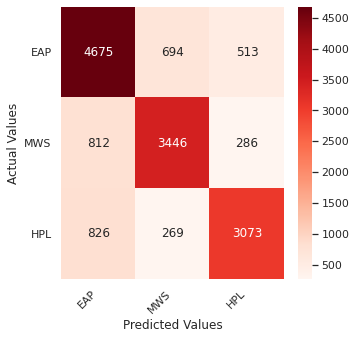

In [110]:
# using seaborn to plot confusion matrix
classes=label_indexer_model.labels
df_cm = pd.DataFrame(train_cfm.toArray().astype(int), index=classes, columns=classes)
fig = plt.figure(figsize=(5,5))
ax = sns.heatmap(df_cm, annot=True, fmt="d", cmap=plt.cm.Reds)
ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right')
ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values');

**Null Accuracy:**

Our model should at least perform better than the `Null Accuracy`. Null Accuracy is defined as the accuracy we would have got if we would have blindly predicted the majority class of the training set as the label.

In [111]:
validation_total = validation_preds_labels.count()

In [112]:
validation_label0_count = validation_preds_labels.filter(F.col("label") == 0.0).count()

validation_label1_count = validation_preds_labels.filter(F.col("label") == 1.0).count()

validation_label2_count = validation_preds_labels.filter(F.col("label") == 2.0).count()

In [113]:
# If we would have predicted everything to be the majority label then what would have been the accuracy
print(f'Null Accuracy: {max(validation_label0_count, validation_label1_count, validation_label2_count) / validation_total}')

Null Accuracy: 0.40481444332998995


**Observation:** The model accuracy on the validation set is 0.76 i.e. it is at least doing better than the NULL accuracy.

## 7. Test Predictions

### 7.1. Prepare Test Set

Load test csv and generate features on the test data.

In [114]:
test_df = spark.read.csv(f'{DATA_PATH}/test.csv', sep=',', escape='"', header=True)

In [115]:
test_df.cache()

DataFrame[id: string, text: string]

In [116]:
# Use the UDF to extract the tokens and count features
lemma_test_df = (test_df
 .withColumn('lemmatize', udf_lemmatize('text'))
)

In [117]:
lemma_test_df.cache()

DataFrame[id: string, text: string, lemmatize: struct<words:array<string>,word_count:int,punct_count:int>]

In [118]:
lemma_test_df = lemma_test_df.select(F.col("id"),
                    F.col("text"),
                    F.col("lemmatize.words").alias("words"),
                    F.col("lemmatize.word_count").alias("word_count"),
                    F.col("lemmatize.punct_count").alias("punct_count")
                   ).cache()

In [119]:
w2v_test_df = w2vec_model.transform(lemma_test_df)

In [120]:
w2v_test_df.cache()

DataFrame[id: string, text: string, words: array<string>, word_count: int, punct_count: int, w2v_features: vector]

In [121]:
w2v_test_df.show(truncate=25)

+-------+-------------------------+-------------------------+----------+-----------+-------------------------+
|     id|                     text|                    words|word_count|punct_count|             w2v_features|
+-------+-------------------------+-------------------------+----------+-----------+-------------------------+
|id02310|Still, as I urged our ...|[still, urged, leaving...|        10|          3|[-0.08469615071662702,...|
|id24541|If a fire wanted fanni...|[fire, wanted, fanning...|        28|          7|[0.032268588564225605,...|
|id00134|And when they had brok...|[broken, frail, door, ...|        17|          3|[0.07538044106160455,-...|
|id27757|While I was thinking h...|[thinking, possibly, m...|        20|          5|[0.005342547642067075,...|
|id04081|I am not sure to what ...|[sure, limit, knowledg...|         5|          1|[0.0808280269149691,-0...|
|id27337|"The thick and peculia...|[thick, peculiar, mist...|        17|          8|[0.13549172089380376,0...|
|

In [122]:
assembled_test_df = vector_assembler.transform(w2v_test_df)

In [123]:
assembled_test_df.cache()

DataFrame[id: string, text: string, words: array<string>, word_count: int, punct_count: int, w2v_features: vector, features: vector]

### 7.2. Persist assembled Test Set

We persist the data into `parquet` format. We can checkpoint and persist intermediate steps so that next time when we want to resume the notebook we do not have to start from scratch.

In [124]:
assembled_test_df.write.parquet(f'{DATA_PATH}/assembled_test_parquet', mode="overwrite")

In [125]:
# cleanup
assembled_test_df.unpersist()

DataFrame[id: string, text: string, words: array<string>, word_count: int, punct_count: int, w2v_features: vector, features: vector]

## 8. Generate Prediction from Test Data for Kaggle Submission

We already persisted our prepared test dataset so that we do not have to re-rerun the whole notebook again. We can resume from that checkpoint.

We have also persisted the trained Logistic Regression Model before. We should be able to load and deserialize the model and use that for test predictions.

### 8.1. Load Model and Generate Test Predictions

In [126]:
# Load Model
from pyspark.ml.classification import LogisticRegressionModel

loaded_lrModel = LogisticRegressionModel.load(MODEL_PATH)

In [127]:
# Load Test Data
assembled_test_df = spark.read.parquet(f'{DATA_PATH}/assembled_test_parquet')

In [128]:
test_preds = loaded_lrModel.transform(assembled_test_df)

In [129]:
test_preds.cache()

DataFrame[id: string, text: string, words: array<string>, word_count: int, punct_count: int, w2v_features: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [130]:
test_preds.select('id', 'text', 'features', 'probability', 
                  F.col('prediction').cast('integer').alias('prediction')).show(10)

+-------+--------------------+--------------------+--------------------+----------+
|     id|                text|            features|         probability|prediction|
+-------+--------------------+--------------------+--------------------+----------+
|id02310|Still, as I urged...|[-0.0846961507166...|[0.16808778432063...|         1|
|id24541|If a fire wanted ...|[0.03226858856422...|[0.50474218011844...|         0|
|id00134|And when they had...|[0.07538044106160...|[0.51476645327095...|         0|
|id27757|While I was think...|[0.00534254764206...|[0.41314068195587...|         2|
|id04081|I am not sure to ...|[0.08082802691496...|[0.82271250253222...|         0|
|id27337|"The thick and pe...|[0.13549172089380...|[0.46716340972094...|         0|
|id24265|That which is not...|[0.34284786507487...|[0.48373170562219...|         0|
|id25917|I sought for repo...|[0.02432371798204...|[0.15938853813998...|         1|
|id04951|Upon the fourth d...|[-0.0455600175940...|[0.73693532528676...|    

### 8.2. Unwrap Probability Vector into Separate Columns

In Spark DF the predicted probabilities are of type vectorAArray. We cannot use them directly for `Kaggle` submission. We leverage the the `vector_to_array` function introduced in Saprk 3.0 to convert a vector array to seperate columns.

We need to be careful of the order of the author labels. So, we refer to the `label_indexer_model` to get the order of the labels.

In [131]:
test_preds.select('id', 'probability').show(10, truncate=False)

+-------+------------------------------------------------------------+
|id     |probability                                                 |
+-------+------------------------------------------------------------+
|id02310|[0.16808778432063567,0.7434265466422694,0.0884856690370951] |
|id24541|[0.5047421801184427,0.22402030930616645,0.2712375105753907] |
|id00134|[0.5147664532709573,0.1277844436522366,0.35744910307680594] |
|id27757|[0.4131406819558747,0.06666915090595932,0.520190167138166]  |
|id04081|[0.8227125025322222,0.10707660423808735,0.07021089322969042]|
|id27337|[0.467163409720947,0.1684921125129696,0.3643444777660834]   |
|id24265|[0.48373170562219064,0.08312598114874317,0.4331423132290662]|
|id25917|[0.1593885381399874,0.6326053282432431,0.20800613361676945] |
|id04951|[0.7369353252867629,0.08768741038811892,0.1753772643251183] |
|id14549|[0.4159451206735398,0.407799082215353,0.17625579711110737]  |
+-------+------------------------------------------------------------+
only s

In [132]:
test_preds.select('id', 'probability').printSchema()

root
 |-- id: string (nullable = true)
 |-- probability: vector (nullable = true)



**Labels Order**

In [133]:
label_indexer_model.labels

['EAP', 'MWS', 'HPL']

**Unwrap Vector Array to Columns (Spark 3.0+)**

Use `vector_to_array` of `pyspark.ml.functions` from `Spark 3.0.0`.

In [134]:
from pyspark.ml.functions import vector_to_array

spark_submission_df = (test_preds
    .withColumn("probas", vector_to_array("probability"))
    .select(F.col('id'),
            F.col('probas')[0].alias('EAP'), 
            F.col('probas')[1].alias('MWS'), 
            F.col('probas')[2].alias('HPL'))
    ).cache()

In [135]:
spark_submission_df.show(10, truncate=False)

+-------+-------------------+-------------------+-------------------+
|id     |EAP                |MWS                |HPL                |
+-------+-------------------+-------------------+-------------------+
|id02310|0.16808778432063567|0.7434265466422694 |0.0884856690370951 |
|id24541|0.5047421801184427 |0.22402030930616645|0.2712375105753907 |
|id00134|0.5147664532709573 |0.1277844436522366 |0.35744910307680594|
|id27757|0.4131406819558747 |0.06666915090595932|0.520190167138166  |
|id04081|0.8227125025322222 |0.10707660423808735|0.07021089322969042|
|id27337|0.467163409720947  |0.1684921125129696 |0.3643444777660834 |
|id24265|0.48373170562219064|0.08312598114874317|0.4331423132290662 |
|id25917|0.1593885381399874 |0.6326053282432431 |0.20800613361676945|
|id04951|0.7369353252867629 |0.08768741038811892|0.1753772643251183 |
|id14549|0.4159451206735398 |0.407799082215353  |0.17625579711110737|
+-------+-------------------+-------------------+-------------------+
only showing top 10 

**Unwrap Vector Array to Columns (Spark < 3.0.0)**

If you are using Spark 2.x then create a custom `udf` to extract an individual element from the vector array as shown below.

In [136]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

first_element = udf(lambda v: float(v[0]), FloatType())
test_preds.select('id', first_element('probability').alias('EAP')).show(3)

+-------+----------+
|     id|       EAP|
+-------+----------+
|id02310|0.16808778|
|id24541| 0.5047422|
|id00134|0.51476645|
+-------+----------+
only showing top 3 rows



### 8.3. Prepare Kaggle Submission

In [137]:
sample_submission_df = spark.read.csv(f'{DATA_PATH}/sample_submission.csv', sep=',', escape='"', header=True)

In [138]:
# check the order of the columns from the sample submission
sample_submission_df.show(3)

+-------+-----------------+-----------------+-----------------+
|     id|              EAP|              HPL|              MWS|
+-------+-----------------+-----------------+-----------------+
|id02310|0.403493538995863|0.287808366106543|0.308698094897594|
|id24541|0.403493538995863|0.287808366106543|0.308698094897594|
|id00134|0.403493538995863|0.287808366106543|0.308698094897594|
+-------+-----------------+-----------------+-----------------+
only showing top 3 rows



In [139]:
# select the order of columns as in the sample submission
spark_submission_df.select('id', 'EAP', 'HPL', 'MWS').repartition(1).write.csv(f'{DATA_PATH}/spark_submission_df_csv', header=True, mode="overwrite")

In [140]:
!ls {DATA_PATH}/spark_submission_df_csv

_SUCCESS  part-00000-0ce3a782-8256-4352-b641-44d4466ab5b8-c000.csv


We need to upload the `part-00000-b80f3c02-1df8-4fcb-a51c-9415e61bddbf-c000.csv` for Kaggle submission.

In [141]:
spark.stop()

**References"**  
These resources helped me a lot to understand about Tokenization, Word2Vec, WordCloud and related NLP techniques. Please visit these notebooks, they are great resources on their own merit.
+ https://www.kaggle.com/thibaultgiordan/text-mining-with-spark
+ https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial
+ https://www.kaggle.com/bkarabay/simple-text-classification-with-apache-spark
+ https://www.kaggle.com/goodwanghan/us-election-eda-sentiment-analysis-on-fugue-spark